In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from nltk import FreqDist
from wordcloud import WordCloud
from pathlib import Path

Se consulta los datos en la pagina oficial de Conagua, se pasan los datos manualmente desde el año 2020 al 2025 a un archivo Excel para cada año https://smn.conagua.gob.mx/es/climatologia/temperaturas-y-lluvias/resumenes-mensuales-de-temperaturas-y-lluvias.

Se sube a un diccionario vacio los csv que se tienen

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
carpeta = Path("/content/drive/MyDrive/Bedu_Lluvias")
dataframes = {}  # diccionario vacío

for archivo in carpeta.glob('*.csv'):
    nombre_tabla = archivo.stem
    dataframes[nombre_tabla] = pd.read_csv(archivo, dtype=str, low_memory=False, na_filter=True)

In [ ]:
# se confirma si se subieron los csv
for k in dataframes.keys():
    print(k)

2020
2021
2022
2023
2024
2025


In [ ]:
df_2025=dataframes["2025"]
df_2024=dataframes["2024"]
df_2023=dataframes["2023"]
df_2022=dataframes["2022"]
df_2021=dataframes["2021"]
df_2020=dataframes["2020"]

In [ ]:
# primeras filas para verificar que se haya subido bien el csv y se le definio su var
df_2025.head()

,Estado,Ene,Feb,Mar,Abr,May,Jun,Jul,Ago,Sep,Oct,Nov,Dic,Anual
0,Aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,BajaCalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN
2,BajaCaliforniaSur,1.2,0.0,0.7,0.7,1.1,3.5,8.4,46.9,62.4,NaN,NaN,NaN,NaN
3,Campeche,37.9,69.7,14.2,14.6,28.6,189.7,121.6,175.8,652.0,NaN,NaN,NaN,NaN
4,Coahuila,3.4,2.0,6.4,6.1,35.9,28.3,64.5,25.3,171.8,NaN,NaN,NaN,NaN


En esta parte se realiza la limpieza y normalizacion de los datos que trabajaremos, se hace la conversion de minusculas y los datos numericos a tipo float, tambien el manejo de nulos

In [ ]:
for anio, df in dataframes.items():
    # columnas a minusculas
    df.columns = df.columns.str.lower()

    # contenido a minusculas en columnas con valores tipo object
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].map(lambda x: x.lower() if isinstance(x, str) else x)

        # reemplazar valores de texto que representan nulos por NaN real
        df[col] = df[col].replace(
            ["nan", "null", "none", "na", "", " "],
            np.nan
        )
        # convertir a valores numericos
        for col in df.select_dtypes(include="object").columns:
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                pass

    dataframes[anio] = df

In [ ]:
# primeras filas para ver si se convirtierona  minusculas
df_2025.head()

,estado,ene,feb,mar,abr,may,jun,jul,ago,sep,oct,nov,dic,anual
0,aguascalientes,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2,NaN,NaN,NaN,NaN
1,bajacalifornia,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4,NaN,NaN,NaN,NaN
2,bajacaliforniasur,1.2,0.0,0.7,0.7,1.1,3.5,8.4,46.9,62.4,NaN,NaN,NaN,NaN
3,campeche,37.9,69.7,14.2,14.6,28.6,189.7,121.6,175.8,652.0,NaN,NaN,NaN,NaN
4,coahuila,3.4,2.0,6.4,6.1,35.9,28.3,64.5,25.3,171.8,NaN,NaN,NaN,NaN


In [ ]:
# Se hace la exploracion del tipo de datos que sean correctos.
df_2025.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33 entries, 0 to 32
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   estado  33 non-null     object 
 1   ene     33 non-null     float64
 2   feb     33 non-null     float64
 3   mar     33 non-null     float64
 4   abr     33 non-null     float64
 5   may     33 non-null     float64
 6   jun     33 non-null     float64
 7   jul     33 non-null     float64
 8   ago     33 non-null     float64
 9   sep     33 non-null     float64
 10  oct     0 non-null      float64
 11  nov     0 non-null      float64
 12  dic     0 non-null      float64
 13  anual   0 non-null      float64
dtypes: float64(13), object(1)
memory usage: 3.7+ KB


Se comienza con el apartado de estimados de locación y variabilidad

In [ ]:
resultados = {}

for anio, df in dataframes.items():
    num = df.select_dtypes(include=["number"]).copy()

    # deteccion de valores atipicos con IQR
    Q1 = num.quantile(0.25)
    Q3 = num.quantile(0.75)
    IQR = Q3 - Q1
    lim_inf = Q1 - 1.5 * IQR
    lim_sup = Q3 + 1.5 * IQR

    # mascara de valores validos
    mask = ~((num < lim_inf) | (num > lim_sup))
    num_sin_outliers = num.where(mask, np.nan)

    # estimadores de locación
    locacion = pd.DataFrame({
        "media": num_sin_outliers.mean(),
        "mediana": num_sin_outliers.median(),
        "moda": num_sin_outliers.mode().iloc[0]
    })

    # estimadores de variabilidad
    variabilidad = pd.DataFrame({
        "rango": num_sin_outliers.max() - num_sin_outliers.min(),
        "varianza": num_sin_outliers.var(),
        "desviacion_estandar": num_sin_outliers.std(),
        "coef_var_%": (num_sin_outliers.std() / num_sin_outliers.mean()) * 100
    })

    # estadisticos de orden
    orden = pd.DataFrame({
        "minimo": num_sin_outliers.min(),
        "Q1": num_sin_outliers.quantile(0.25),
        "mediana": num_sin_outliers.median(),
        "Q3": num_sin_outliers.quantile(0.75),
        "maximo": num_sin_outliers.max()
    })

    # concatena los resultados
    resumen = pd.concat([locacion, variabilidad, orden], axis=1)
    resultados[anio] = resumen

Años disponibles: ['2020', '2021', '2022', '2023', '2024', '2025']
Selecciona un año: 2021

Columnas disponibles: ['media', 'mediana', 'moda', 'rango', 'varianza', 'desviacion_estandar', 'coef_var_%', 'minimo', 'Q1', 'mediana', 'Q3', 'maximo']
Selecciona la columna a graficar: media

Tipos de gráfico disponibles: barra, linea, histograma, boxplot
Selecciona el tipo de gráfico: linea


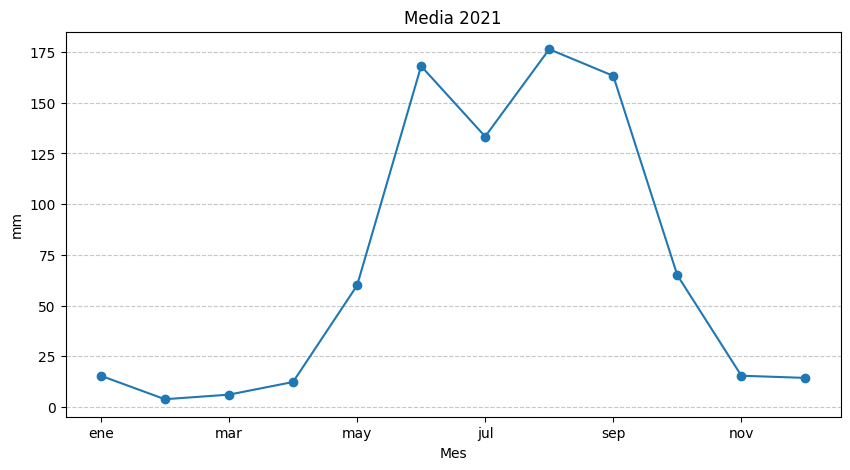

In [ ]:
# mostrar años disponibles
print("Años disponibles:", list(resultados.keys()))
anio = input("Selecciona un año: ")

if anio.isdigit() and str(anio) in resultados:
    anio = str(anio)
    df = resultados[anio]
    # eliminamos la fila 'anual' antes de graficar
    df = df[df.index != 'anual']

    print("\nColumnas disponibles:", list(df.columns))
    columna = input("Selecciona la columna a graficar: ")

    print("\nTipos de gráfico disponibles: barra, linea, histograma, boxplot")
    tipo = input("Selecciona el tipo de gráfico: ").lower()

    plt.figure(figsize=(10,5))

    if tipo == "barra":
        df[columna].plot(kind="bar", title=f"{columna.capitalize()} {anio}")
    elif tipo == "linea":
        df[columna].plot(kind="line", marker="o", title=f"{columna.capitalize()} {anio}")
    elif tipo == "histograma":
        plt.hist(df[columna].dropna(), bins=10)
        plt.title(f"Histograma de {columna} ({anio})")
    elif tipo == "boxplot":
        plt.boxplot(df[columna].dropna())
        plt.title(f"Boxplot de {columna} ({anio})")
    else:
        print("Tipo de gráfico no válido.")

    plt.ylabel("mm")
    plt.xlabel("Mes")
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    plt.show()

else:
    print("Año no válido.")

No es necesario realizar un análisis exhaustivo de variables categóricas en este conjunto de datos, ya que el contenido se centra principalmente en variables numéricas continuas, como la precipitación en milímetros, y solo cuenta con categorías simples como “mes” y “estado”. Estas variables categóricas no interactúan entre sí de manera que justifique el uso de tablas de contingencia o pruebas de asociación, puesto que su función es únicamente identificar la ubicación temporal y geográfica de los registros. En este caso, el enfoque más adecuado es el análisis descriptivo y comparativo de la precipitación mediante estimadores de tendencia central y dispersión, complementado con visualizaciones gráficas por estado y mes que permiten interpretar la variabilidad y los patrones climáticos sin requerir un análisis categórico adicional.

No se puede realizar la correlacion en este analisis, ya que no hay variables numericas distintas para encontrar una asociarlas en la actividad.

Años disponibles: ['2020', '2021', '2022', '2023', '2024', '2025']
Selecciona un año: 2021


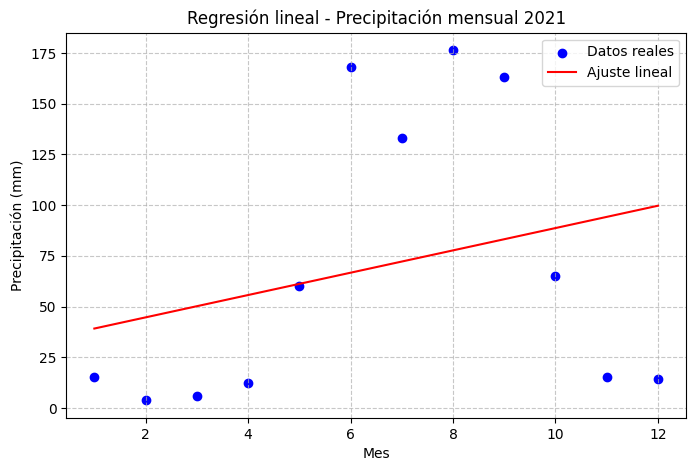


=== RESULTADOS DE REGRESIÓN ===
Pendiente: 5.503
Intercepto: 33.661
Coeficiente de determinación R²: 0.079
Interpretación: la precipitación tiende a aumentar conforme avanza el año.


In [ ]:
# mostrar años disponibles en el diccionario 'resultados'
print("Años disponibles:", list(resultados.keys()))
anio = input("Selecciona un año: ")

# nos aseguramos que el input se trate como una cadena de texto
try:
    anio = str(anio)
# recuperamos el DataFrame para el año seleccionado
    df = resultados[anio].reset_index()

    # filtramos la fila 'anual' antes de la regresión lineal, porque únicamente queremos los valores mensuales
    df_mensual = df[df['index'] != 'anual'].copy()

    # REGRESIÓN LINEAL SIMPLE
    # verificamos si existe la columna 'mes'. Si es así, utilizamos pd.factorize
    # para convertir estos nombres en categorías numéricas
    if "mes" in df_mensual.columns:
        df_mensual["mes_num"] = pd.factorize(df_mensual["mes"])[0] + 1
    # si no hay una columna 'mes', se crea
    else:
        df_mensual["mes_num"] = np.arange(1, len(df_mensual) + 1)

    # extraemos los valores del mes y la media de las precipitaciones
    X = df_mensual[["mes_num"]].values
    y = df_mensual["media"].values
    # creamos un modelo de regresión lineal para encontrar el mejor ajuste
    modelo = LinearRegression().fit(X, y)
    # extraemos la pendiente obtenida de la regresión
    # la cual nos indica cuánto cambia y (precipitación) por unidad de x (mes)
    pendiente = modelo.coef_[0]
    # extraemos el intercepto, que es la precipitación predicha cuando el mes es 0
    intercepto = modelo.intercept_
    # calculamos la R cuadrada para evaluar qué tan bien explica el modelo la variabilidad de nuestros datos
    r2 = modelo.score(X, y)

    # gráfico
    plt.figure(figsize=(8, 5))
    # muestra los valores de precipitación media mensual como puntos azules
    plt.scatter(df_mensual["mes_num"], y, color="blue", label="Datos reales")
    # traza la línea de regresión en rojo
    plt.plot(df_mensual["mes_num"], modelo.predict(X), color="red", label="Ajuste lineal")
    # se añaden los títulos, ejes y cuadricula para mejor visualización
    plt.title(f"Regresión lineal - Precipitación mensual {anio}")
    plt.xlabel("Mes")
    plt.ylabel("Precipitación (mm)")
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

    # RESULTADOS NUMÉRICOS
    # se imprimen los valores calculados de la pendiente, intercepto y R cuadrada
    print("\n=== RESULTADOS DE REGRESIÓN ===")
    print(f"Pendiente: {pendiente:.3f}")
    print(f"Intercepto: {intercepto:.3f}")
    print(f"Coeficiente de determinación R²: {r2:.3f}")
    # se muestran las interpretaciones posibles de los valores obtenidos de la pendiente
    if pendiente > 0:
        print("Interpretación: la precipitación tiende a aumentar conforme avanza el año.")
    elif pendiente < 0:
        print("Interpretación: la precipitación tiende a disminuir conforme avanza el año.")
    else:
        print("Interpretación: no se observa una tendencia lineal significativa.")
  # en caso de que el usuario introduzca un año que no se encuentre disponible
except (KeyError, ValueError):
    print("Año no válido o datos no disponibles.")

Como se puede observar los valores obtenidos de R² son muy bajos, por lo que el modelo de regresión lineal no logra explicar bien la variabilidad de la precipitación mensual, por lo que es posible decir que otros factores están influyendo en la precipitación.

# **Modelo de predicción de precipitaciones**

Se probará construir un modelo de regresión que prediga la precipitación en un mes, dadas las precipitaciones en los meses anteriores.
1. Se construirán dos versiones:
   - La primera tomará los datos de todos los estados.
   - La segunda tomará únicamente los datos de un estado.
2. Se probarán diferentes números de meses $n$ para cada versión (2-12 meses).

De esta manera se buscará obtener aquella configuración que produzca el mejor modelo de regresión lineal por validación cruzada, evaluando por medio del coeficiente de determinación (R²).


**Entrenamiento del modelo:**

Dado nuestro conjunto de datos, utilizaremos una "ventana deslizante" de $n + 1$ columnas a lo largo del conjunto, tomando las primeras $n$ columnas como los atributos del modelo y la última columna como la etiqueta a predecir.

Se cargan los datos de todos los años en una sola tabla, modificando los nombres de las columnas agregándoles el año al que corresponden. Como los últimos meses del 2025 no tienen datos de precipitación, se eliminan estas columnas.

In [ ]:
dfs = [] # Inicializamos la lista aquí
for i in range(6):
    df = pd.read_csv(f"{carpeta}/202{i}.csv", index_col="Estado", usecols=range(13))
    df.columns = df.columns + f"_202{i}"
    dfs.append(df)

df = pd.concat(dfs, axis="columns").dropna(axis="columns")
df

,Ene_2020,Feb_2020,Mar_2020,Abr_2020,May_2020,Jun_2020,Jul_2020,Ago_2020,Sep_2020,Oct_2020,...,Dic_2024,Ene_2025,Feb_2025,Mar_2025,Abr_2025,May_2025,Jun_2025,Jul_2025,Ago_2025,Sep_2025
Estado,,,,,,,,,,,,,,,,,,,,,
Aguascalientes,38.5,28.4,1.5,4.6,17.3,72.6,162.8,77.3,81.9,4.5,...,1.7,9.5,0.0,0.0,0.1,32.7,157.8,143.8,139.3,483.2
BajaCalifornia,4.3,10.5,62.4,11.8,0.6,0.0,1.1,0.5,1.1,0.5,...,0.1,3.8,4.7,28.9,3.2,2.4,5.4,0.3,7.8,56.4
BajaCaliforniaSur,1.9,8.8,36.9,0.2,0.0,0.8,6.6,22.4,17.8,3.6,...,0.0,1.2,0.0,0.7,0.7,1.1,3.5,8.4,46.9,62.4
Campeche,31.1,13.4,4.1,25.9,207.1,499.1,137.2,184.8,234.2,293.1,...,24.0,37.9,69.7,14.2,14.6,28.6,189.7,121.6,175.8,652.0
Coahuila,11.3,2.8,21.6,7.3,30.5,23.8,44.5,6.0,63.8,0.4,...,4.2,3.4,2.0,6.4,6.1,35.9,28.3,64.5,25.3,171.8
Colima,80.1,112.1,0.0,0.0,2.1,84.7,354.8,664.3,339.2,27.0,...,1.5,14.9,0.1,0.0,0.0,69.5,389.3,247.2,373.5,1094.5
Chiapas,28.4,46.9,21.0,32.4,239.4,409.1,182.5,345.9,373.1,251.8,...,46.0,48.0,51.3,21.6,55.4,134.8,422.3,167.5,244.3,1145.1
Chihuahua,6.0,20.2,27.3,3.3,6.2,19.5,82.8,32.4,49.1,0.1,...,0.1,11.4,0.0,0.8,2.6,6.2,75.8,104.7,79.0,280.4
CiudaddeMéxico,11.3,5.3,8.1,21.9,32.8,59.7,103.8,107.8,97.0,20.1,...,3.0,12.3,11.7,8.4,2.5,64.6,211.6,131.4,173.7,616.1


Creamos una función de utilidad que tome la tabla anterior y un valor de $n$, y produzca una tabla de $n$ columnas que almacenarán las precipitaciones de $n$ meses anteriores y una serie de números que contendrán las precipitaciones del mes que queremos predecir.

In [ ]:
def create_time_series_dataset(df: pd.DataFrame, n: int):
    data = []
    targets = []
    n_windows = df.shape[1] - n

    for start in range(n_windows):
        end = start + n
        data.append(df.iloc[:, start:end].values)
        targets.append(df.iloc[:, end].values)

    return np.concatenate(data), np.concatenate(targets)

A continuación, se muestra un ejemplo donde se usarían cuatro meses para predecir el quinto.

In [ ]:
create_time_series_dataset(df, 4)

(array([[ 38.5,  28.4,   1.5,   4.6],
        [  4.3,  10.5,  62.4,  11.8],
        [  1.9,   8.8,  36.9,   0.2],
        ...,
        [ 60.8, 146.8,  87.3, 146.3],
        [ 26.9,  89.8, 125.3, 111. ],
        [ 43.1, 155.5, 113.9, 122.2]]),
 array([ 17.3,   0.6,   0. , ..., 557.6, 364.8, 481.1]))

Creamos la primera versión del modelo, donde utilizamos todos los datos (con $n$ entre 2 y 12 meses), y guardamos los resultados en una lista.

Para cada $n$ creamos un modelo con  'LinearRegression' que se evaluará con validación cruzada.


In [ ]:
months = range(2, 13)
all_scores = []

for n in months:
    data, target = create_time_series_dataset(df, n)
    model = LinearRegression()
    scores = cross_val_score(model, data, target)
    all_scores.append(scores)

results = pd.DataFrame(all_scores, index=months).T
results.index.name = "r2"
results.columns.name = "meses"
results

meses,2,3,4,5,6,7,8,9,10,11,12
r2,,,,,,,,,,,
0,0.423549,0.418122,0.329415,0.291393,0.277411,0.320517,0.283875,0.290691,0.415484,0.463018,0.545214
1,0.393890,0.340383,0.339897,0.437465,0.462775,0.527712,0.515291,0.479896,0.497773,0.522180,0.635569
2,0.468938,0.438807,0.495479,0.466208,0.479475,0.447942,0.401343,0.322835,0.439454,0.469313,0.420527
3,0.262588,0.261936,0.291535,0.314169,0.314075,0.347320,0.363839,0.390826,0.354722,0.427076,0.389853
4,0.215654,0.178196,0.209776,0.221713,0.219404,0.216272,0.221732,0.208319,0.203445,0.274532,0.367252


Para visualizar estos resultados se contruye una gráfica tipo boxplot donde el eje $x$ será el número de meses empleados para la predicción y $y$ será los valores de R². En esta gráfica los valores más altos de R² indican las mejores predicciones.


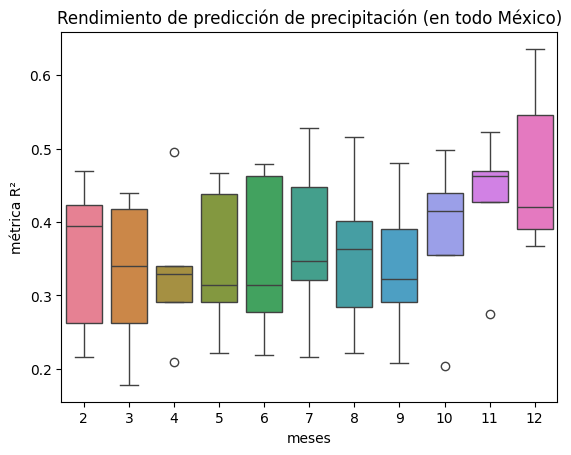

In [ ]:
fig, ax = plt.subplots()
sns.boxplot(results, ax=ax)
plt.ylabel("métrica R²")
plt.title("Rendimiento de predicción de precipitación (en todo México)")
plt.savefig("LluviasPrediccionBoxPlot.png", dpi=300)

Podemos observar en la gráfica que entre más meses anteriores utilicemos para predecir un mes dado, mejor será el modelo. Específicamente al utilizar la información de 12 meses se obtienen las mejores predicciones, lo que indica que conocer los datos de precipitación del año anterior ayuda a predecir las precipitaciones del año actual.

Con la segunda versión del modelo, en la cual se usará la información por estado de manera independiente, se espera obtener un modelo más ajustado que uno general para todo México, esto debido a que las condiciones ambientales son diferentes en cada estado del país.

In [ ]:
states = df.index
months = range(2, 13)
results_data = []

for state in states:
    for n in months:
        data, target = create_time_series_dataset(df.loc[[state]], n)
        model = LinearRegression()
        scores = cross_val_score(model, data, target)
        results_data.append([state, n, scores.mean()])

state_results = pd.DataFrame(results_data, columns=["estado", "meses", "media"])
state_results = state_results.pivot(columns="meses", index="estado", values="media")

# Pondremos "Nacional" hasta el final de la tabla
state_results = pd.concat([
    state_results.drop("Nacional"), state_results.loc[["Nacional"]]
])

state_results

meses,2,3,4,5,6,7,8,9,10,11,12
estado,,,,,,,,,,,
Aguascalientes,0.185910,0.189536,0.209018,0.238063,0.014183,0.050749,-0.152886,-0.273058,-0.297125,-0.129393,-0.541369
BajaCalifornia,-0.079655,-0.164921,-0.175531,-0.226118,-0.308024,-0.306980,-0.359543,-0.275767,-0.606671,-0.703007,-0.338445
BajaCaliforniaSur,-0.109234,-0.516054,-0.455179,-0.551655,-0.645438,-5.463175,-5.257075,-5.676533,-0.955693,-0.759194,-2.615659
Campeche,0.130200,0.106944,0.100675,0.225454,0.326371,0.262111,0.234584,-0.007756,-0.375512,-0.294666,-0.179319
Chiapas,0.259365,0.157237,0.267682,0.318768,0.442370,0.414672,0.383219,0.335131,0.297963,0.247272,0.246168
Chihuahua,0.105122,0.152846,0.142916,0.115594,-0.597246,-0.919754,-0.892058,-1.443431,-1.730489,-2.204384,-4.838477
CiudaddeMéxico,0.423652,0.237050,0.185009,0.132712,0.074253,0.049700,0.039727,-0.009352,-0.153299,-0.109622,-0.293251
Coahuila,-0.099988,-0.080794,-0.067793,-0.005463,-0.410822,-0.576043,-0.530800,-0.527083,-0.282805,-0.298735,-0.441658
Colima,0.190229,0.212542,0.216045,0.269297,0.278781,0.259426,0.121597,-0.033022,0.079824,0.078205,0.145221


Como podemos visualizar en la tabla de resultados, las predicciones dan muy bajos rendimientos, por lo que para facilitar la visualización creamos un heatmap con los resultados mayores a cero.

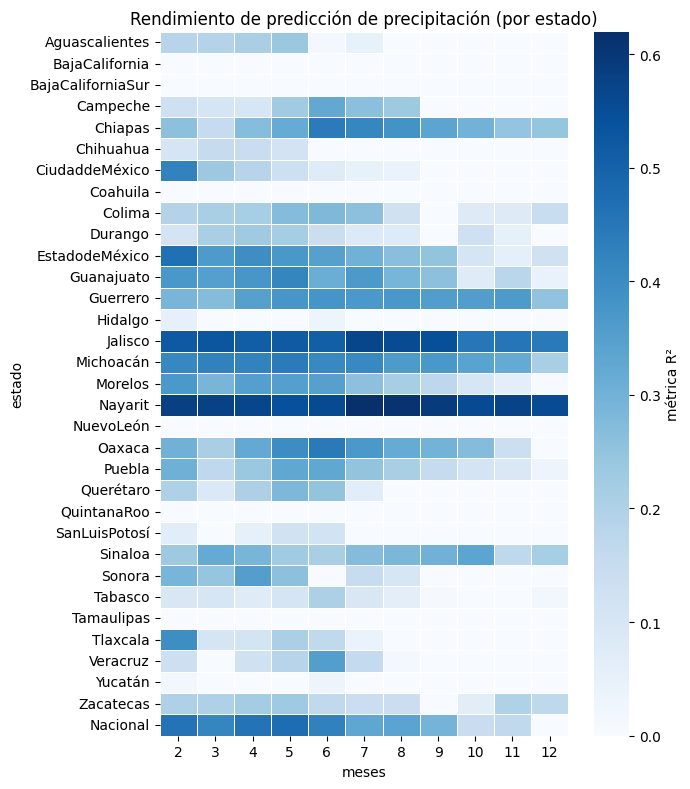

In [ ]:
fig, ax = plt.subplots(figsize=(7, 8))
sns.heatmap(
    state_results,
    vmin=0,
    cmap="Blues",
    linewidths=0.5,
    ax=ax,
    cbar_kws={"label": "métrica R²"}
)
ax.set_title("Rendimiento de predicción de precipitación (por estado)")
fig.set_layout_engine("tight")
fig.savefig("LluviasPrediccionHeatmap.png", dpi=300)

En esta última figura observamos que con esta versión del modelo, en algunos estados es más fácil predecir las precipitaciones (como en Nayarit y Jalisco), mientras que para estados como Baja California y Nuevo León es más complicado.

Para la predicción de precipitaciones a nivel nacional, observamos que conforme aumenta el número de meses, va empeorando el rendimiento, contrario a la primer versión del modelo.